# Post of elbow detection: dimensionality reduction

The aim of this notebook is to generate some illustrative plots to motivate where elbow detection might be needed.

In [1]:
import numpy as np
import numpy.random as npr

import scipy as sp
import scipy.stats as sp_sts

import sklearn as sk
import sklearn.decomposition as sk_dec

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as pp
import matplotlib.cm as cm

import IPython.display as ipyd

import typing as tp

## Generate random data

Generate a cloud of normally distributed random data in $n$ dimensions. Firstly choose the number of independent variables, how many dimensions there will be overall, and how many points there will be

In [2]:
independent_var_count = 32
full_dimension_count = 64
point_count = 70

Next, generate normally distributed variables with different variances and then couple and embed them into the space with target dimensionality

In [3]:
def get_random_cloud(
    independent_var_count: int=independent_var_count,
    full_dimension_count: int=full_dimension_count,
    point_count: int=point_count
)->np.ndarray:
    # prepare variances
    var_variance_arr = npr.rand(independent_var_count)

    # prepare array with different variable in each column 
    # and observations along rows
    obs_arr_list = []
    #
    for i_var, var_variance in enumerate(var_variance_arr):
        cur_obs = npr.normal(loc=0.0, scale=np.sqrt(var_variance), size=point_count)
        obs_arr_list.append(cur_obs)
    #
    obs_mat = np.stack(obs_arr_list, axis=1)

    # generate a random othrogonal matrix and use it to mix variables and embed them into
    # the space of target dimensionality
    mix_mat = sp_sts.ortho_group.rvs(full_dimension_count)[:independent_var_count, :]
    emb_obs_mat = obs_mat @ mix_mat
    
    return emb_obs_mat

Orthogonal matrix here is used to get `full_dimension_count` random orthogonal column-vectors. These vectors are then truncated to  `independent_var_count` components, and are thus no longer orthogonal. These non-orthogonal columns are then
used to couple `independent_var_count` realizations of independent random variables.

The end result is that the cloud of normally distributed random variables, of dimension `independent_var_count` gets randomly rotated and embedded into space with dimensionality `full_dimension_count`.

Another way of looking at it is that we get orthogonal row-vectors and selecting the first `independent_var_count` of them. We then embed the randomly generated data by assigning the first random variable to run along the direction of the first selected orthogonal row-vector etc.

## Apply PCA to estimate the dimensionality of the data

Use principle component analysis to estimate the number of dimensions in the original dataset

In [4]:
dim_count_arr = np.arange(full_dimension_count)+1
noise_mag = 3e-1
run_count = 10

fit_dict_list = []
#
for i_run in range(run_count): # repeat for several runs
    emb_obs_mat = get_random_cloud(
        independent_var_count=independent_var_count,
        full_dimension_count=full_dimension_count,
        point_count=point_count
    ) # random data for each run
    
    for n_dim in dim_count_arr: # go through dimensions

        # fit a PCA model then transform the source data using it
        # then reverse the transform
        pca_model = sk_dec.PCA(n_components=n_dim).fit(emb_obs_mat)
        reproduced_emb_obs_mat = pca_model.inverse_transform(pca_model.transform(emb_obs_mat))

        # add noise
        reproduced_emb_obs_mat += (2*npr.rand(*reproduced_emb_obs_mat.shape) - 1)*noise_mag

        # compare to the original
        diff_mat = emb_obs_mat - reproduced_emb_obs_mat
        err2_vec = np.sqrt(np.sum(np.abs(diff_mat)**2, axis=1)/np.sum(np.abs(emb_obs_mat)**2, axis=1))

        # extract the error and save
        fit_dict_list.append({
            'run': i_run,
            'n_dim': n_dim,
            'err': np.sqrt(np.mean(err2_vec))
        })
        
    print(f'\r ({i_run+1})/({run_count}) done', end='')

print('\nFinished')

fit_df = pd.DataFrame(fit_dict_list)

fit_df.head(5)

 (10)/(10) done
Finished


,run,n_dim,err
0,0,1,1.007783
1,0,2,0.982690
2,0,3,0.964066
3,0,4,0.943044
4,0,5,0.914015


## Plot results 

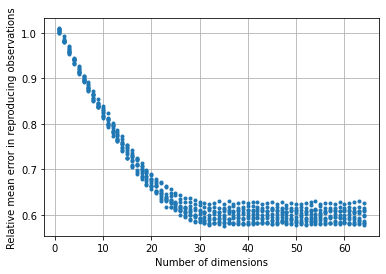

In [5]:
fig, ax = pp.subplots(figsize=(6, 4))

ax.plot(fit_df.n_dim, fit_df.err, '.')

ax.set_xlabel('Number of dimensions')
ax.set_ylabel('Relative mean error in reproducing observations')
ax.grid()